# [Paris Saclay Center for Data Science](http://www.datascience-paris-saclay.fr)

<img src="youtube-money.jpg" width="250", ALIGN="right"/>

## Youtube - Video success classification

_Mehdi Cherti (CNRS), Balázs Kégl (CNRS)_

_Team : Lou-Andréa Chauvelot, Thomas Bessou, Hoël Plantec, Ashley Hill, Erwann Martin et Adrien Pavao._
    
## Introduction

Youtube has beacome a huge platform in today's internet image. Every buiness needs or has a channel on this social media website. however, it is clear that these companies are having trouble making popular videos on this platform. It is clear from a buisness point of view that maximizing view counts is ideal, but how can a company go about doing this?
We need to be able predict possible popularity from metadata we set to any given video. For example, which description is ideal? how relevent is the channel's base popularity?
Hence this challenge. If we are able to predict with a good degree of accuracy the views on videos, we would be able to tune our metadata to maximize view counts.

## Data

The dataset was generated by crawling videos from Youtube, and getting the metadata associated to the videos. 

* title : the title of the video (String)
* length : the length of the video (Long)
* category : the youtube category (String)
* published : the date on which is was published to youtube (date)
* duration : the duration of the video (hh:mm:ss)
* description : the description associated to the video (string)
* keywords : the keywords used to search the video

The title, descriptions and keywords are mostly in english, but can be in Korean, Japanese, Vietnamise, Chinese and Russian.

## The prediction task

In this challenge, we chose to split the view counts, into view classes:

$$
\begin{array}{|l|c|c|}
\hline
\text{Class} & \text{min views} & \text{max views}\\
\hline
\hline
0 & 0         & 401         \\
\hline
1 & 401       & 2,975       \\
\hline
2 & 2,975     & 21,987      \\
\hline
3 & 21,987    & 162,700     \\
\hline
4 & 162,700   & 1,201,195   \\
\hline
5 & 1,201,195 & 191,241,705 \\
\hline
\end{array}
$$

Where the goal is to predict the correct class.

### Requirements

* numpy>=1.10.0  
* matplotlib>=1.5.0 
* pandas>=0.19.0  
* scikit-learn>=0.17 (different syntaxes for v0.17 and v0.18)   
* seaborn>=0.7.1
* nltk

Further, an nltk dataset needs to be downloaded:

```
python -m nltk.downloader popular
```

In [1]:
import os
import numpy as np
import pandas as pd

%matplotlib inline

pd.set_option('display.max_rows', 500)

# The data

In [2]:
df = pd.read_csv('data/train.csv')
df['published'] = pd.to_datetime(df['published'])
df.head(10)

,title,viewcount,length,category,published,duration,description,keywords,view_class
0,#1 BIEBER FAN!!!!,8043,84,Comedy,2012-02-10 23:31:49,00:01:24,Best friends\r\ndskhgw324432432ksf\r\ndskhgw32...,"['Yay', 'dskhgw324432432ksf']",2
1,DUMB GIRL FALLS BAD!!,350,36,Comedy,2011-08-30 17:06:08,00:00:36,"lol , funny!","['funny', 'girl', 'falls', 'ouch', 'hurts', 'p...",0
2,"100,000",63052,33,Comedy,2010-05-23 03:11:26,00:00:33,Thanks!,"['subscribers', 'dom', 'fera', 'fear', 'domini...",3
3,Don't judge too quickly (part3),43876,30,Comedy,2007-09-04 14:21:52,00:00:30,Don't judge too quickly (part3),"[""Don't"", 'judge', 'too', 'quickly', '(part3)']",3
4,Messi Jackson !!,393,29,Comedy,2011-10-15 23:15:40,00:00:29,P.E.S 2012 lolll,"['Messi', 'Jackson', '!!']",0
5,max ploeg Lego en klei,504,30,Comedy,2011-10-30 11:46:03,00:00:30,Stopmotion,"['Timelaps', 'Lego', 'Funny']",1
6,This is How My Son Does Dishes,4679900,55,Comedy,2011-11-05 22:23:40,00:00:55,Frankie asked if I could put Smooth Criminal o...,"['dance', 'Dance Music', 'smooth criminal', 'c...",5
7,Funniest kid ever!,13283930,90,Comedy,2006-12-22 07:29:06,00:01:30,This kid gets the worst case of stage fright e...,"['stage', 'fright', 'kid', 'funny', 'hilarious']",5
8,clip cf hai,914,46,Comedy,2011-09-19 09:31:57,00:00:46,,"['video', 'cf', 'cua', 'linhshaker']",1
9,Drunk Alcoholic Fish frenzy,4711,41,Comedy,2011-10-10 18:49:25,00:00:41,Fish that go into a frezny when you feed them ...,"['Fish', 'Alcohol intoxication', 'drink', 'dru...",2


In [3]:
df.dtypes

title                  object
viewcount               int64
length                  int64
category               object
published      datetime64[ns]
duration               object
description            object
keywords               object
view_class              int64
dtype: object

In [4]:
df.describe()

,viewcount,length,view_class
count,9.941000e+03,9941.000000,9941.000000
mean,7.661635e+05,60.409416,2.415552
std,4.174166e+06,34.773726,1.624707
min,4.000000e+00,17.000000,0.000000
25%,1.048000e+03,41.000000,1.000000
50%,2.334400e+04,58.000000,3.000000
75%,2.605690e+05,74.000000,4.000000
max,1.912417e+08,900.000000,5.000000


It has been found that the logarithm of the view count is nicely distributed :

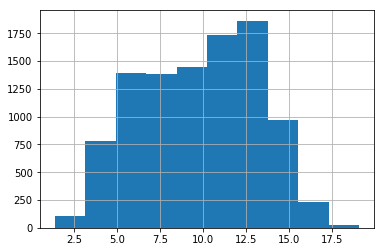

In [5]:
df.viewcount.apply(np.log).hist()

Hence, we created 6 relatively equilibrated classes representing that view count (`view_class`) using the following formula :

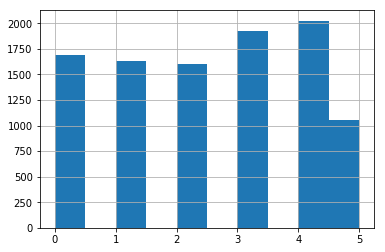

In [6]:
df.viewcount.apply(np.log).apply(lambda x: int(round((np.clip(x,5,15)-5)/2))).hist()

Class 0 corresponds to ~100 views, while class 5 corresponds to several million views.

NB: For information, here is the distribution of the log of the length (in seconds) of the videos.

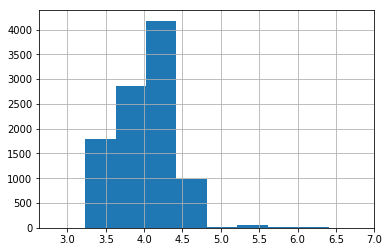

In [7]:
df.length.apply(np.log).hist()

## The pipeline

For submitting at the [RAMP site](http://ramp.studio), you will have to write two classes, saved in two different files:   
* the class `FeatureExtractor`, which will be used to extract features for classification from the dataset and produce a numpy array of size (number of samples $\times$ number of features). 
* a class `Classifier` to predict 

Note that the following code cells are *not* executed in the notebook. The notebook saves their contents in the file specified in the first line of the cell, so you can edit your submission before running the local test below and submitting it at the RAMP site.

### Feature extraction

In [3]:
%%file submissions/starting_kit/feature_extractor.py

import nltk
import numpy as np
import pandas as pd
import unicodedata
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer


def lmap(f, l):
    return list(map(f, l))


def amap(f, l):
    return np.array(lmap(f, l))


class FeatureExtractor:
    def strip_accents_unicode(self, s):
        try:
            s = unicode(s, 'utf-8')
        except NameError:  # unicode is a default on python 3
            pass
        s = unicodedata.normalize('NFD', s)
        s = s.encode('ascii', 'ignore')
        s = s.decode("utf-8")
        return str(s)

    def clean_str(self, sentence, stem=True):
        sentence = self.strip_accents_unicode(sentence)
        words = list(
            filter(lambda t: t.isalpha(), nltk.word_tokenize(sentence)))
        if stem:
            stemmer = nltk.stem.SnowballStemmer('english').stem
            words = lmap(stemmer, words)
        return words

    def __init__(self, stem_tfidf=True):
        self.stem_tfidf = stem_tfidf
        self.dummies_extractors = {}

    # called with either fit or add to True
    def process_dummies(self, col, parser=None, fit=False, add=False):
        if fit:
            (self.dummies_extractors)[col] = DictVectorizer(
                sparse=False, dtype=np.int64)
        to_dummy = self.data[col]
        if parser is not None:  # list mode
            to_dummy = to_dummy.apply(parser).apply(pd.Series).stack()

        dummies = pd.get_dummies(
            to_dummy, prefix=col, prefix_sep='_').sum(level=0)

        if fit and add:
            dict_ = dummies.to_dict('records')
            dummies_wdrop = (self.dummies_extractors[col]).fit_transform(dict_)
            self.out = pd.concat(
                [self.out,
                 pd.DataFrame(dummies_wdrop).add_prefix(col + '_')],
                axis=1,
                ignore_index=True)

        elif fit:  # only
            dict_ = dummies[:1].to_dict('records')
            (self.dummies_extractors)[col].fit(dict_)

        else:  # add only
            dict_ = dummies.to_dict('records')
            dummies_wdrop = (self.dummies_extractors[col]).transform(dict_)
            self.out = pd.concat(
                [self.out,
                 pd.DataFrame(dummies_wdrop).add_prefix(col + '_')],
                axis=1,
                ignore_index=True)

    def process_tfidf(self, col, stem=None, fit=False, add=False):

        if stem is None:
            stem = self.stem_tfidf

        words = map(lambda x: self.clean_str(x, stem=stem), self.data[col])
        statement_preprocess = lmap(lambda w: ' '.join(w), words)

        if fit and add:
            (self.dummies_extractors)[col] = TfidfVectorizer(analyzer='word')
            transformed = (self.dummies_extractors
                           )[col].fit_transform(statement_preprocess)
            tfidfdf = pd.DataFrame(transformed.todense()).add_prefix(col)
            self.out = pd.concat(
                [self.out, tfidfdf], axis=1, ignore_index=True)

        elif fit:  # only
            (self.dummies_extractors)[col] = TfidfVectorizer(analyzer='word')
            (self.dummies_extractors)[col].fit(statement_preprocess)

        else:  # add only
            transformed = (
                self.dummies_extractors)[col].transform(statement_preprocess)
            tfidfdf = pd.DataFrame(transformed.todense()).add_prefix(col)
            self.out = pd.concat(
                [self.out, tfidfdf], axis=1, ignore_index=True)

    def _fit(self, y=None, fit=True, transform=True):
        self.process_tfidf('description', fit=fit, add=transform)
        self.process_tfidf('title', fit=fit, add=transform)
        self.process_dummies('category', fit=fit, add=transform)

    def _fit_transform(self, X_df, y=None, fit=True, transform=True):

        self.out = self.data[[]].copy()
        self.out['aff'] = 1  # Make any linear regression affine

        self._fit(y, fit, transform)

        self.out = pd.concat(
            [self.out, self.data.length], axis=1, ignore_index=True)
        self.out.fillna(0, inplace=True)

    def fit(self, X_df, y=None):
        self.data = X_df.reset_index(drop=True, inplace=False)
        self._fit(y, fit=True, transform=False)
        return self

    def fit_transform(self, X_df, y=None):
        self.data = X_df.reset_index(drop=True, inplace=False)
        self._fit_transform(X_df, y, fit=True, transform=True)
        return self.out.values

    def transform(self, X_df):
        self.data = X_df.reset_index(drop=True, inplace=False)
        self._fit_transform(X_df, y=None, fit=False, transform=True)
        return self.out.values


Overwriting submissions/starting_kit/feature_extractor.py


### Feature extraction overview

Before going through the code, we first need to understand how **tf-idf** works. A **Term Frequency** is a count of how many times a word occurs in a given document (synonymous with bag of words). The **Inverse Document Frequency** is the number of times a word occurs in a corpus of documents. **tf-idf** is used to weight words according to how important they are. Words that are used frequently in many documents will have a lower weighting while infrequent ones will have a higher weighting.


`CountVectorizer` converts a collection of text documents to a matrix of token (*word*) counts. This implementation produces a sparse representation of the counts to be passed to the `TfidfTransformer`.
The `TfidfTransformer` transforms a count matrix to a normalized tf or tf-idf representation.

A `TfidfVectorizer` does these two steps. 

The feature extractor overrides *fit* by providing the `TfidfVectorizer` with a new preprocessing step that has been presented before.

The ``FeatureExtractor`` class is used to extract features
from text documents. It is based on the [`TfidfVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer) class from scikit-learn which is a [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) followed by [`TfidfTransformer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer).  

See the [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) for a general introduction to text feature extraction.


### Improving  feature extraction

#### Preprocessing 

The document preprocessing can be customized in in the `clean_str` function, for instance to remove accents.

see also the `stip_accents` option of [`TfidfVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).


##### Stopword removal
The most frequent words often do not carry much meaning. Examples: *the, a, of, for, in, ...*. 

Stop words removal can be enabled by passing the `stopwords='english'` parameter at the initialization of the
[`TfidfVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). 

A custom list of stop words (e.g. from NLTK) can also be used.

##### Word / character n-grams

By default, the bag of words model is use in the starting kit. To use word or character n-grams, the `analyser` and `ngram_range` parameters of [`TfidfVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) should be changed.


##### Stemming  and Lemmatization

English words like *look* can be inflected with a morphological suffix to produce *looks, looking, looked*. They share the same stem *look*. Often (but not always) it is beneficial to map all inflected forms into the stem. The most commonly used stemmer is the Porter Stemmer. The name comes from its developer, Martin Porter. `SnowballStemmer('english')` from *NLTK* is used. This stemmer is called Snowball, because Porter created a programming language with this name for creating new stemming algorithms.

Seming can be enabled with a custom `token_processor` function.

## Classifier

The classifier follows a classical scikit-learn classifier template. It should be saved in the file [`submissions/starting_kit/classifier.py`](/edit/submissions/starting_kit/classifier.py). In its simplest form it takes a scikit-learn pipeline, assigns it to `self.clf` in `__init__`, then calls its `fit` and `predict_proba` functions in the corresponding member functions.

In [4]:
%%file submissions/starting_kit/classifier.py

import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.base import BaseEstimator


def lmap(f, l):
    return list(map(f, l))


def amap(f, l):
    return np.array(lmap(f, l))


class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = ExtraTreesClassifier(max_depth=10, random_state=42)

    def fit(self, X, y):
        self.clf.fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        y_pred = self.predict(X)
        return amap(lambda tr: [1 if i == tr else 0 for i in range(6)], y_pred)


Overwriting submissions/starting_kit/classifier.py


## Local testing (before submission)

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. For this we provide a unit test. Note that the test runs on your files in [`submissions/starting_kit`](/tree/submissions/starting_kit), not on the classes defined in the cells of this notebook.

First `pip install ramp-workflow` or install it from the [github repo](https://github.com/paris-saclay-cds/ramp-workflow). Make sure that the python files `feature_extractor.py` and `classifier.py` are in the  [`submissions/starting_kit`](/tree/submissions/starting_kit) folder, and the data `train.csv` and `test.csv` are in [`data`](/tree/data). Then run

```ramp_test_submission```

If it runs and print training and test errors on each fold, then you can submit the code.

In [37]:
!ramp_test_submission --quick-test

Testing Youtube: Classify popularity of videos
Reading train and test files from ./data ...
Reading cv ...
Training ./submissions/starting_kit ...
CV fold 0
	score   sacc   acc
	train  0.884  0.85
	valid  0.375  0.30
	test   0.319  0.19
CV fold 1
	score   sacc    acc
	train  0.859  0.825
	valid  0.450  0.300
	test   0.323  0.200
CV fold 2
	score   sacc    acc
	train  0.875  0.838
	valid  0.420  0.300
	test   0.355  0.220
CV fold 3
	score   sacc   acc
	train  0.895  0.85
	valid  0.375  0.30
	test   0.402  0.27
----------------------------
Mean CV scores
----------------------------
	score            sacc             acc
	train  0.878 ± 0.0132  0.841 ± 0.0104
	valid  0.405 ± 0.0318       0.3 ± 0.0
	test    0.35 ± 0.0332   0.22 ± 0.0308
----------------------------
Bagged scores
----------------------------
	score   sacc
	valid  0.414
	test   0.350


## Submitting to [ramp.studio](http://ramp.studio)

Once you found a good feature extractor and classifier, you can submit them to [ramp.studio](http://www.ramp.studio). First, if it is your first time using RAMP, [sign up](http://www.ramp.studio/sign_up), otherwise [log in](http://www.ramp.studio/login). Then find an open event on the particular problem, for example, the event fake_news ([Saclay Datacamp](http://www.ramp.studio/events/fake_news_saclay_datacamp_17), [DataFest Tbilisi](https://www.ramp.studio/events/fake_news_tbilisi)) for this RAMP. Sign up for the event. Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your sandbox ([Saclay Datacamp](http://www.ramp.studio/events/fake_news_saclay_datacamp_17/sandbox), [DataFest Tbilisi](https://www.ramp.studio/events/fake_news_tbilisi/sandbox)) and copy-paste (or upload) [`feature_extractor.py`](/edit/submissions/starting_kit/feature_extractor.py) and [`classifier.py`](/edit/submissions/starting_kit/classifier.py) from `submissions/starting_kit`. Save it, rename it, then submit it. The submission is trained and tested on our backend in the same way as `ramp_test_submission` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in my submissions ([Saclay Datacamp](http://www.ramp.studio/events/fake_news_saclay_datacamp_17/my_submissions), [DataFest Tbilisi](https://www.ramp.studio/events/fake_news_tbilisi/my_submissions)). Once it is trained, you get a mail, and your submission shows up on the public leaderboard ([Saclay Datacamp](http://www.ramp.studio/events/fake_news_saclay_datacamp_17/leaderboard), [DataFest Tbilisi](https://www.ramp.studio/events/fake_news_tbilisi/leaderboard)). 
If there is an error (despite having tested your submission locally with `ramp_test_submission`), it will show up in the "Failed submissions" table in my submissions ([Saclay Datacamp](http://www.ramp.studio/events/fake_news_saclay_datacamp_17/my_submissions), [DataFest Tbilisi](https://www.ramp.studio/events/fake_news_tbilisi/my_submissions)). You can click on the error to see part of the trace.

After submission, do not forget to give credits to the previous submissions you reused or integrated into your submission.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, perhaps do some AutoML/hyperopt, etc., _locally_, and checking them with `ramp_test_submission`. The script prints mean cross-validation scores.

The official score in this RAMP (the first score column after "historical contributivity" on the leader board ([Saclay Datacamp](http://www.ramp.studio/events/fake_news_saclay_datacamp_17/leaderboard), [DataFest Tbilisi](https://www.ramp.studio/events/fake_news_tbilisi/leaderboard)) is smoothed accuracy, so the line that is relevant in the output of `ramp_test_submission` is `valid sacc = 0.339 ± 0.08`. When the score is good enough, you can submit it at the RAMP.

## More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).

## Contact

Don't hesitate to [contact us](mailto:admin@ramp.studio?subject=Youtube notebook).